In [7]:
input_class = 3

In [8]:
import os
import pydicom
import numpy as np
from skimage.transform import resize
import pandas as pd


# Load the CSV file into a pandas DataFrame
df = pd.read_csv(r"D:\Project_vk\results.csv")

# Function to extract row values based on the input class
def extract_row_values(input_class):
    # Filter rows based on the input class
    selected_rows = df[df['class'] == input_class]
    
    # Extract xmin, ymin, xmax, ymax values from the selected row
    if not selected_rows.empty:
        row_values = selected_rows.iloc[0][['xmin', 'ymin', 'xmax', 'ymax']].values
        return tuple(row_values)
    else:
        return None

row_values = extract_row_values(input_class)
row_values = tuple(int(value) for value in row_values)

if row_values:
    print("Extracted row values:", row_values)
else:
    print("No matching rows found for the input class.")



#save cropped

import os
import pydicom
import numpy as np
from skimage.transform import resize

# Define the directory containing DICOM files for extraction
dicom_dir = r"D:\Project_vk\Registration\Sorted_DEC2"

# Define the directory to save the extracted, cropped, and resized DICOM files
output_dir = r"D:\Project_vk\Registration\CROP_DEC2"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the range of image numbers to extract and crop
start_index = row_values[1]
end_index = row_values[3]
bbox_y_start = row_values[0]
bbox_y_end = row_values[2]
bbox_x_start = 215
bbox_x_end = 303

# Define the target size for resizing
target_size = (60, 60)

# Extract, crop, resize, and save DICOM files
for i in range(start_index, end_index + 1):
    # Define input and output paths
    input_path = os.path.join(dicom_dir, f"{i}.dcm")
    output_path = os.path.join(output_dir, f"{i}.dcm")

    # Read the DICOM file
    dicom_data = pydicom.dcmread(input_path)

    # Check if DICOM file is valid
    if dicom_data:
        # Crop the DICOM file
        pixel_array = dicom_data.pixel_array
        cropped_pixel_array = pixel_array[bbox_y_start:bbox_y_end, bbox_x_start:bbox_x_end]

        # Resize the cropped DICOM image
        resized_image = resize(cropped_pixel_array, target_size, anti_aliasing=True, preserve_range=True)

        # Convert the resized image to uint16
        resized_image = resized_image.astype(np.uint16)

        # Update DICOM metadata
        dicom_data.Rows, dicom_data.Columns = target_size
        dicom_data.PixelData = resized_image.tobytes()

        # Save the resized DICOM file
        dicom_data.save_as(output_path)
    else:
        print(f"Error loading DICOM file: {input_path}")

print("DICOM files extracted, cropped, resized, and saved successfully.")

#crop slices

import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
import pydicom

# Define the directory containing DICOM files
dicom_dir = r"D:\Project_vk\Registration\CROP_DEC2"

# Load DICOM files
dicom_files = [os.path.join(dicom_dir, filename) for filename in os.listdir(dicom_dir)]

# Print the length of dicom_files
print("Number of DICOM files in dicom_dir:", len(dicom_files))

# Sort DICOM files by instance number
dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

# Read DICOM metadata
first_slice = pydicom.dcmread(dicom_files[0])

# Load DICOM pixel data
slices = [pydicom.dcmread(file).pixel_array for file in dicom_files]

# Convert slices to numpy array
vol = np.stack(slices)

# Display the shape of the loaded windowed volume
print("Shape of loaded CT volume (windowed):", vol.shape)

n0, n1, n2 = vol.shape

# Initialize selected_values dictionary
selected_values_sagittal = None
selected_values_coronal = None

# Interactive function to crop sagittal slice
@interact(sagittal_slice=(0, n2 - 1), 
          x_start_sagittal=widgets.IntSlider(min=0, max=n1, step=1, value=0),
          x_end_sagittal=widgets.IntSlider(min=0, max=n1, step=1, value=n1),
          y_start_sagittal=widgets.IntSlider(min=0, max=n0, step=1, value=0),
          y_end_sagittal=widgets.IntSlider(min=0, max=n0, step=1, value=n0))
def crop_sagittal_slice(sagittal_slice=264, x_start_sagittal=272, x_end_sagittal=359, y_start_sagittal=78, y_end_sagittal=326):
    global sagittal_values
    sagittal_values = {'x_start': x_start_sagittal, 'x_end': x_end_sagittal, 'y_start': y_start_sagittal, 'y_end': y_end_sagittal}
    
    cropped_slice_sagittal = vol[y_start_sagittal:y_end_sagittal, x_start_sagittal:x_end_sagittal, sagittal_slice]
    
    # Plot coronal slice
    coronal_slice = n1 // 2  # Middle slice
    x_start_coronal = 0
    x_end_coronal = n2
    cropped_slice_coronal = vol[:, x_start_coronal:x_end_coronal, coronal_slice]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    # Plot sagittal slice
    ax.imshow(cropped_slice_sagittal, cmap='gray')
    ax.axis('off')
    ax.set_title('Cropped Sagittal Slice')
    
    
    plt.show()

# Interactive function to crop coronal slice
@interact(coronal_slice=(0, n1 - 1), 
          y_start=widgets.IntSlider(min=0, max=n0, step=1, value=0),
          y_end=widgets.IntSlider(min=0, max=n0, step=1, value=n0),
          z_start=widgets.IntSlider(min=0, max=n2, step=1, value=0),
          z_end=widgets.IntSlider(min=0, max=n2, step=1, value=n2))
def crop_coronal_slice(coronal_slice=306, y_start=82, y_end=349, z_start=215, z_end=307):
    global coronal_values
    coronal_values = {'z_start': z_start, 'z_end': z_end}
    
    cropped_slice = vol[y_start:y_end, coronal_slice, z_start:z_end]
    
    # Display the cropped slice
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cropped_slice, cmap='gray')
    ax.axis('off')
    ax.set_title('Cropped Coronal Slice')
    
    plt.show()




Extracted row values: (289, 231, 347, 329)
DICOM files extracted, cropped, resized, and saved successfully.
Number of DICOM files in dicom_dir: 99
Shape of loaded CT volume (windowed): (99, 60, 60)


interactive(children=(IntSlider(value=59, description='sagittal_slice', max=59), IntSlider(value=0, descriptio…

interactive(children=(IntSlider(value=59, description='coronal_slice', max=59), IntSlider(value=0, description…

In [1]:
import os
import numpy as np
import pydicom
import torch
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr 


dicom_dir = "D:\Project_vk\Registration\perfect"

# Load DICOM files
dicom_files = [os.path.join(dicom_dir, filename) for filename in os.listdir(dicom_dir)]

# Sort DICOM files by instance number
dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

# Read DICOM metadata
first_slice = pydicom.dcmread(dicom_files[0])
spacing = [0.703125, 0.703125, 0.625]  # Example spacing values
#spacing =[0.519531, 0.519531, 0.625]#murr
#slice_thickness = first_slice.SliceThickness
#spacing = first_slice.PixelSpacing

# Load DICOM pixel data and clip intensities
clip_min = -150
clip_max = 4500

slices = [np.clip(pydicom.dcmread(file).pixel_array, clip_min, clip_max) for file in dicom_files]

# Convert slices to numpy array
volume = np.stack(slices)
volume = np.array(volume, dtype=np.ndarray)
volume = volume.astype(np.float32)

# Display information about the loaded volume
print(f"Volume shape: {volume.shape}")
print(f"Spacing: {spacing}")

# Calculate bounding box dimensions (assuming equal spacing between slices)
#bx, by, bz = [49.0, 45.0, 40.0]  # Example bounding box dimensions
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
print(bx, by, bz)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

torch.cuda.empty_cache()

#slices = [pydicom.dcmread(file).pixel_array for file in dicom_files]

Volume shape: (103, 60, 60)
Spacing: [0.703125, 0.703125, 0.625]
36.2109375 21.09375 18.75
cuda


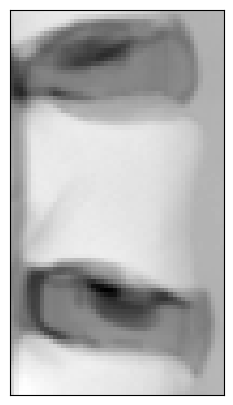

In [10]:
 X = "sagittal"
if X == "sagittal":
    WIDTH = 55
    pitch_angle = 90
else:
    WIDTH = 75
    pitch_angle = 180


HEIGHT = 90
WIDTH = 50
DELX = 1.5

#PERFORM DRR
yaw_angle = 90  # Adjust the yaw angle
#pitch_angle = 180 # Adjust the pitch angle
roll_angle = 0
yaw_angle_rad = np.radians(yaw_angle)
pitch_angle_rad = np.radians(pitch_angle)
roll_angle_rad = np.radians(roll_angle)# Adjust the roll angle
# Create a new rotation tensor with the desired angles
rotation = torch.tensor([[yaw_angle_rad, pitch_angle_rad, roll_angle_rad]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)
rotation = rotation.float()

drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=474.6,   # Source-to-detector radius (half of the source-to-detector distance)
    height=HEIGHT,
    width=WIDTH,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=DELX,    # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
#rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)
translation = translation.float()

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

In [7]:
#perform crop xray
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
import pydicom
from skimage.transform import resize
from skimage import transform
# Load the DICOM file
dicom_path = r'D:\Project_vk\Registration\data\1027.dcm'
dicom = pydicom.dcmread(dicom_path, force=True)

xray_row_resize = 600
xray_column_resize = 600
# Extract pixel data and convert to numpy array
dicom_pixel_array = 1 - (dicom.pixel_array - dicom.pixel_array.min()) / (dicom.pixel_array.max() - dicom.pixel_array.min())  # Normalize pixel values
# Rotate the image
dicom_pixel_array = transform.rotate(dicom_pixel_array, 0)
dicom_pixel_array = resize(dicom_pixel_array, (xray_row_resize,xray_column_resize),anti_aliasing=True, preserve_range=True)
# Initialize selected_values dictionary
selected_values_xray = None

# Interactive function to crop X-ray image
@interact(x_start=widgets.IntSlider(min=0, max=dicom_pixel_array.shape[1], step=1, value=0),
          x_end=widgets.IntSlider(min=0, max=dicom_pixel_array.shape[1], step=1, value=dicom_pixel_array.shape[1]),
          y_start=widgets.IntSlider(min=0, max=dicom_pixel_array.shape[0], step=1, value=0),
          y_end=widgets.IntSlider(min=0, max=dicom_pixel_array.shape[0], step=1, value=dicom_pixel_array.shape[0]))
def crop_xray_dicom(x_start=0, x_end=dicom_pixel_array.shape[1], y_start=0, y_end=dicom_pixel_array.shape[0]):
    global xray_dicom_values
    xray_dicom_values = {'x_start': x_start, 'x_end': x_end, 'y_start': y_start, 'y_end': y_end}

    cropped_xray_dicom = dicom_pixel_array[y_start:y_end, x_start:x_end]

    # Display the cropped X-ray image
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cropped_xray_dicom, cmap='gray')
    ax.axis('off')
    ax.set_title('Cropped X-ray DICOM Image')

    plt.show()


interactive(children=(IntSlider(value=0, description='x_start', max=600), IntSlider(value=600, description='x_…

In [6]:
#crop xray ADJUST HEIGHT AND WIDTH ACC TO DRR
import pydicom
import torch
import torch.nn.functional as F
import numpy as np
from skimage import transform, exposure
import pandas as pd

# Load the DICOM file
#dicom_path = r'D:\DeepLearning\dup\fin\\data\10232.dcm'
dicom_path = r'D:\Project_vk\Registration\data\1027.dcm'
dicom = pydicom.dcmread(dicom_path)

# Extract pixel data and convert to numpy array
dicom_pixel_array = 1 - dicom.pixel_array
dicom_pixel_array = resize(dicom_pixel_array, (xray_row_resize,xray_column_resize),anti_aliasing=True, preserve_range=True)

# Assuming it's RGB DICOM, split into channels
dicom_pixel_array = dicom_pixel_array[:, :,1]
dicom_pixel_array = dicom_pixel_array.astype(np.float32)  # Convert to float32

# Rotate the image
rotated_image = transform.rotate(dicom_pixel_array, 0)


# Extract bounding box values
bbox_x = xray_dicom_values['x_start']
bbox_y = xray_dicom_values['y_start']
bbox_width = xray_dicom_values['x_end']
bbox_height = xray_dicom_values['y_end']

# Crop the rotated image based on bounding box values
cropped_image = rotated_image[bbox_y:bbox_height,bbox_x:bbox_width]
cropped_image = resize(cropped_image, (40,40),anti_aliasing=True, preserve_range=True)

# Convert the cropped image from NumPy array to PyTorch tensor
cropped_tensor = torch.tensor(cropped_image)

# Clamp the intensity values of the cropped tensor from 300 to 1500
clipped_tensor = torch.clamp(cropped_tensor, 0, 65000)



# Reshape the tensor to have batch dimension of 1 and channel dimension of 1
clipped_tensor_reshaped = clipped_tensor.unsqueeze(0).unsqueeze(0)

# Resize the image using bilinear interpolation to the desired shape
desired_shape = (HEIGHT, WIDTH)
resized_clipped_tensor = F.interpolate(clipped_tensor_reshaped, size=desired_shape, mode='bilinear', align_corners=False)


# Ensure the shape is torch.Size([1, 1, 200, 120])
xray = resized_clipped_tensor.view(1, 1, HEIGHT, WIDTH)







In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [9]:
# desired size of the output image
imsize = (90, 50)  # Adjust according to your x-ray size

# No need for loader and image_loader functions if your images are already tensors
style_img = img  # Replace style_tensor with your style image tensor
content_img = xray  # Replace xray_tensor with your x-ray image tensor


assert style_img.size() == content_img.size(), \
    "Style and content images should be of the same size"

print(content_img.max())

tensor(57496.3047)


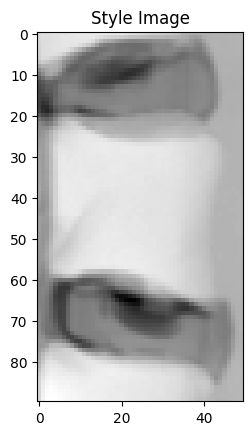

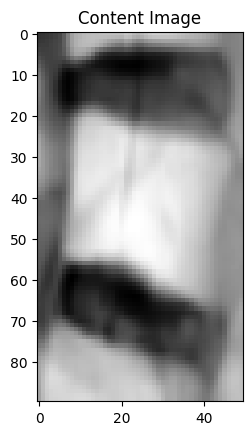

tensor(1.)


In [10]:
def imshow_1(tensor, title=None):
    # Remove batch dimension if present
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)
    # Clone the tensor to avoid modifying the original tensor in-place
    #tensor = tensor.clone()
    # Normalize tensor data to [0, 1]
    tensor /= tensor.max()
    # Convert tensor to numpy array
    image = tensor.cpu().detach().numpy()
    # Ensure image dimensions are in the correct order for imshow (H x W)
    if len(image.shape) == 3:
        image = image.transpose(1, 2, 0)


def imshow(tensor, title=None):
    # Remove batch dimension if present
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)
    # Clone the tensor to avoid modifying the original tensor in-place
    tensor = tensor.clone()
    # Normalize tensor data to [0, 1]
    tensor /= tensor.max()
    # Convert tensor to numpy array
    image = tensor.cpu().detach().numpy()
    # Ensure image dimensions are in the correct order for imshow (H x W)
    if len(image.shape) == 3:
        image = image.transpose(1, 2, 0)
    # Plot the image
    plt.imshow(image, cmap='gray')  # Specify the colormap as 'gray' for grayscale images
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated
    plt.show()  # Show the image


imshow_1(style_img, title='Style Image')
imshow_1(content_img, title='Content Image')


# Now use imshow to display your images
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

print(content_img.max())


In [11]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [13]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [14]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

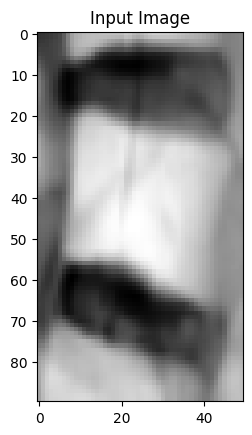

tensor(1.)


In [17]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
print(input_img.max())

In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=90000, content_weight=3.0):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


c:\Users\kanna\anaconda3\envs\torch\lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 8.118791 Content Loss: 6.703841

run [100]:
Style Loss : 4.073374 Content Loss: 6.836132

run [150]:
Style Loss : 2.798684 Content Loss: 6.266663

run [200]:
Style Loss : 2.553310 Content Loss: 6.116395

run [250]:
Style Loss : 2.487785 Content Loss: 6.066515

run [300]:
Style Loss : 2.468068 Content Loss: 6.027850



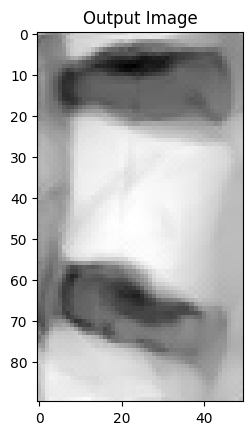

In [20]:
# Move the style and content images to the same device as the model
style_img = style_img.to(device)
content_img = content_img.to(device)

# Ensure the input image is also on the same device
input_img = input_img.to(device)

# Run the style transfer
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Display the output image
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


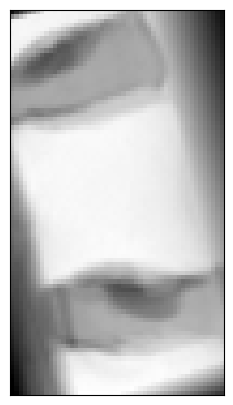

In [21]:
yaw_angle = 110  # Adjust the yaw angle tried(91,100,7)
pitch_angle = 110 # Adjust the pitch angle
roll_angle = 5
yaw_angle_rad = np.radians(yaw_angle)
pitch_angle_rad = np.radians(pitch_angle)
roll_angle_rad = np.radians(roll_angle)# Adjust the roll angle
# Create a new rotation tensor with the desired angles
rotation = torch.tensor([[yaw_angle_rad, pitch_angle_rad, roll_angle_rad]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)
rotation = rotation.float()

drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=474.6,   # Source-to-detector radius (half of the source-to-detector distance)
    height=90,
    width=50,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.5,    # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
#rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translation = torch.tensor([[bx, by, bz]], device=device)
translation = translation.float()

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

In [42]:
from diffdrr.drr import DRR, Registration
from diffdrr.metrics import NormalizedCrossCorrelation2d,Sobel

criterion = NormalizedCrossCorrelation2d()
from skimage.transform import resize
import torch

# Check if img is on CUDA and move it to CPU if necessary
if img.is_cuda:
    img = img.cpu()

# Convert normalized_image and img tensors to Double data type
#normalized_image = normalized_image.float()

# Now you can use img for comparison
print(criterion(output.cpu(), img).item())


AttributeError: 'Sobel' object has no attribute 'shape'

In [43]:
import pandas as pd
from tqdm import tqdm

def optimize(
    reg: Registration,
    img,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    criterion = NormalizedCrossCorrelation2d()
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.get_rotation().squeeze().tolist()
        bx, by, bz = reg.get_translation().squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        estimate = estimate.float()
        img = img.float()
        loss = criterion(img, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.95:
            tqdm.write(f"Converged in {itr} iterations")
            break

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    
    # Extract the max loss and its corresponding parameters
    max_loss_index = df['loss'].idxmax()
    max_loss_params = df.iloc[max_loss_index]
    
    return df, max_loss_params



In [44]:
import os
import torch
from tqdm import tqdm

r = rotation.clone()
t = translation.clone()

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Ensure resized_dicom_tensor is on the same device as other tensors
normalized_image = output.to(device)

# Adam
drr = DRR(volume, spacing, sdr=474.6, height=HEIGHT, width=WIDTH, delx=DELX).to(device)
reg = Registration(
    drr,
    r,
    t,
    parameterization="euler_angles",
    convention="ZYX",
)
params_adam,max_loss_params = optimize(reg, normalized_image, 0.01, 0.1, optimizer="adam")
del drr

# Reset the environment variable after running the script if needed
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ''


print("Max Loss Parameters:")
print(max_loss_params)

  0%|                     | 0/250 [00:00<?, ?it/s]

100%|███████████| 250/250 [00:05<00:00, 43.11it/s]

Max Loss Parameters:
alpha     1.788899
beta      1.613105
gamma     0.260594
bx       35.419872
by       19.758793
bz       14.568084
loss      0.901377
Name: 213, dtype: float64


In [43]:
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate


def animate_in_browser(df, max_length):
    n = max_length - len(df)
    df = pd.concat([df, df.iloc[[-1] * n]])

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=output,
        verbose=True,
        device=device,
        extension=".webp",
        duration=3000,
        parameterization="euler_angles",
        convention="ZYX",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))


drr = DRR(volume, spacing, sdr=476.5, height=HEIGHT,width=WIDTH, delx=DELX).to(device)

animate_in_browser(params_adam, len(params_adam))

Precomputing DRRs: 100%|█████████████████| 250/250 [01:26<00:00,  2.88it/s]


In [40]:
rotations = torch.tensor([[max_loss_params['alpha'], max_loss_params['beta'], max_loss_params['gamma']]], device=device)
translations = torch.tensor([[max_loss_params['bx'], max_loss_params['by'], max_loss_params['bz']]], device=device)
print(rotations)
print(translations)


tensor([[1.7782, 1.6511, 0.2643]], device='cuda:0', dtype=torch.float64)
tensor([[35.3486, 19.8086, 17.2865]], device='cuda:0', dtype=torch.float64)


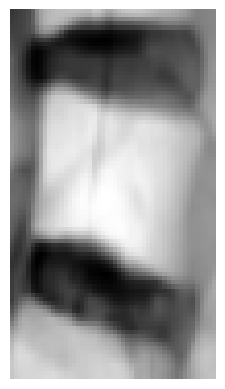

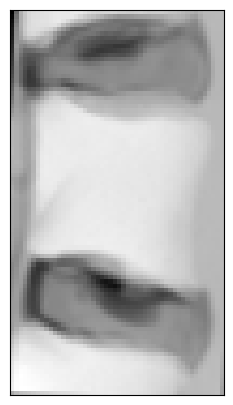

tensor([0.9201], device='cuda:0', grad_fn=<AsStridedBackward0>)


In [46]:
B = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=474.6,   # Source-to-detector radius (half of the source-to-detector distance)
    height=HEIGHT,
    width=WIDTH,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=DELX,    # Pixel spacing (in mm)
).to(device)

b = B(rotations.float(), translations.float(), parameterization="euler_angles", convention="ZYX")
plt.figure()
plt.axis('off')
imshow(content_img)
plot_drr(b, ticks=False)
plt.show()

print(criterion(b,input_img))
